In [1]:
##Borrar datos del entorno
rm(list=ls())

In [2]:
##Crear folders de almacenamiento
dir.create("microdatos", showWarnings = F)

In [41]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,googledrive,janitor,survey,
               sf,httr,jsonlite,showtext)

#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

In [4]:
# Función para descargar y descomprimir un archivo con timeout
download_and_unzip <- function(url, destination="microdatos") {
  tryCatch({
    # Descargar el archivo con timeout
    download.file(url, destfile = paste0(destination, "/", basename(url)), mode = "wb", timeout = 10000)

    # Descomprimir el archivo
    unzip(paste0(destination, "/", basename(url)), exdir = destination)

    # Eliminar el archivo comprimido después de descomprimirlo
    unlink(paste0(destination, "/", basename(url)))

    message(paste("Descarga y descompresión exitosas para", basename(url)))
  }, error = function(e) {
    warning(paste("Error al descargar o descomprimir", basename(url), ":", conditionMessage(e)))
  })
}

In [67]:
crea_grafbarra <- function(data, group_var) {
  fill_color <- "#235b4e"

  # Create the bar chart with the processed data
  p <- ggplot(data, aes(x = {{group_var}}, y = porcentaje)) + 
    geom_bar(stat = "identity", position = position_dodge(width = 0.9), fill = fill_color) +
    geom_text(aes(label = porcentaje), vjust = -0.5, position = position_dodge(width = 0.9), size = 5) +
    labs(
      title = "Porcentaje de viviendas autoproducidas según asistencia técnica",
    x="",
      y = "Porcentaje de Acciones", 
        caption = "Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con datos de
INEGI. Encuesta Nacional de Vivienda 2020",
      fill = as.character(rlang::as_label(rlang::enquo(group_var)))
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "none",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, vjust = 0.5),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop")
    )
  
  return(p)
}

In [5]:
download_and_unzip("https://www.inegi.org.mx/contenidos/programas/envi/2020/microdatos/envi_2020_base_de_datos_csv.zip")


Descarga y descompresión exitosas para envi_2020_base_de_datos_csv.zip



In [6]:
envi2020<-read.csv("microdatos/Bases de datos/TVIVIENDA.csv")%>%
janitor::clean_names()


In [7]:
#Declaración del diseño muestral
options(survey.lonely.psu="adjust")
dm_envi<-envi2020%>%
as_survey(weights= factor, strata=est_dis, ids=upm_dis)

In [16]:
dm_envi%>%
filter(p5_1==4 | p5_1==5 |p5_1==6)%>%
    group_by(p5_1)%>%
    summarise(viviendas=survey_total(),
                porcentaje=survey_prop())%>%
    janitor::adorn_totals("row")

p5_1,viviendas,viviendas_se,porcentaje,porcentaje_se
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4,3760354,103113.21,0.15736612,0.004243843
5,19823188,209547.92,0.82957565,0.004268839
6,312034,20250.36,0.01305823,0.000845271
Total,23895576,332911.49,1.00000000,0.009357953


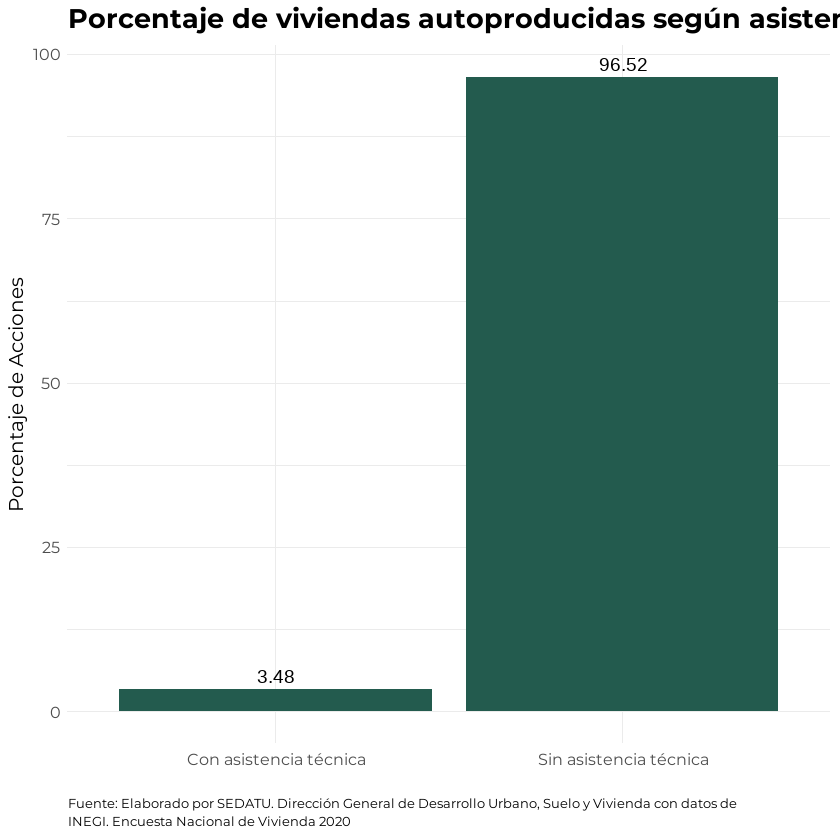

In [68]:
dm_envi%>%
filter(!is.na(p5_12))%>%
filter(p5_12==3 | p5_12==4 |p5_12==5 | p5_12==6)%>%
mutate(asist_tec=
case_when(p5_12==4 | p5_12==5 ~ "Con asistencia técnica",
            TRUE ~ "Sin asistencia técnica"))%>%   
    group_by(asist_tec)%>%
    summarise(viviendas=survey_total(),
                porcentaje=round(survey_prop()*100,2))%>%
crea_grafbarra(asist_tec)

ggsave("autoprod_asist_tec.png", width = 10, height = 7, units = "in", dpi = 100, bg="white")